Definition: Survival analysis is a set of statistical methods to model time to event.

Techniques:
    1. Paramterized
    2. Non Parametrized
        Techniques:
            1.Univariate:
            2. Regression(Semi Parametrized models):
                1. Cox 
                2. Weibull
                3. ATF


In this section we are going to explore Non parametrized regression methods

References:
Model: https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
Packages: https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html

Questions:
    1. Survival regression vs Logistics/ classification model. What is the difference?
        1. In Survival regression methods, we dont have to deal with all the linear regression assumptions
        2. Survival regression help us to plot hazard function for individual/combination of covariates. 
        This way we are able to not only compare cohorts but also look into rate of change of hazard function
        In regression, wse can only look into proportion of churners for individual/combination of covariates
    2. baseline survival curve?
        As is, what is the survival curve looking like. Look into the baseline function plots in this notebook to get an understanding
    3. What are the types of survival regressions available?
        In non parametric models, there is alans additive model, i have not covered it here.
    4. When to use semi parametrized Vs Fully parametrized models:
        https://stats.stackexchange.com/questions/64739/in-survival-analysis-why-do-we-use-semi-parametric-models-cox-proportional-haz
        basically, if we dont know the distribution of covriates, we can model semi. if you know for sure the distribution is normal then we can use maximum liklihood approach else model the data using cox semi which uses partial liklihood function.
    5. How do you measure the performance of the model?
    6. what is hazard function and survival function. if I know hazard function for an individual customer, what does it mean?
        Hazard function is the ratio of PDF to survival rate. A low Hazard function means that the customer will not churn.
    7. How granular shoulld my data be?
        at any given time, Relative time column (now-entry), churn/non churn column, customer characteristics beofre/during
    8. What is the liklihood function?
    

In [ ]:
Practical Application <-- what is this for regression?
For the program
1. Significant covariates which are influencing churn and retention
2. Room for improvment: Prob of churn (or Hazard curve) for individual / combinations of covriates
    Example: TV subscription Vs TV Subscription with Data
3. Furture Changes to program: How does the prob of churn varies if we change values of one individual covariates
4. Descriptive statistics
    What area should i change: People in group A are twice as likely to die at age 80 as people in group B
    How can we prolong churn: Does exposure X decrease the time until event Y?

             
Individual customers: Predict the following.
1. median life
2. Survival function, --> what is the use case?
3. Partial hazard --> what is the use case?


Data: https://www.kaggle.com/blastchar/telco-customer-churn

Survival Regression analysis:
1. EDA (Not doing it right now as it is already covered in previous projects)
    1. Numerical
        Shape, distributions, correlation, 
    2. Categorical
        Anova test to find significant categories withrespect to 
    3. Missing Values:
2. Assumptions testing:
    Resource: https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
    1. Basic assumption is the Hazard function is same for all the individuals but will only vary by a vector. A detailed
       
3. Feature Engineering
4. Modelling
5. Result interpretation
    1. Covariates significance, co-effs, 
    2. hazard function plot for individual/combo of covariates
    3. how does the hazard function changes WRT to baseline function
    4. if needed, plot out baseline survival and hazard function
6. Predtiction:
    1. Survival Function
    2. Hazard function
    3. mean life time

Assumptions:
    The proportional hazard assumption is that all individuals have the same hazard function, but a unique scaling factor infront. So the shape of the hazard function is the same for all individuals, and only a scalar infront changes.

hi(t)=aih(t)
At the core of the assumption is that ai is not time varying, that is, ai(t)=ai. Further more, if we take the ratio of this with another subject (called the hazard ratio):

hi(t)hj(t)=aih(t)ajh(t)=aiaj
is constant for all t. In this tutorial we will test this non-time varying assumption, and look at ways to handle violations.

In [6]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


In [15]:
from lifelines import CoxPHFitter
df=pd.read_csv("C:/Users/thand/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_r= df[['tenure', 'Churn', 'gender', 'Partner', 'Dependents', 'PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data

,tenure,Churn,gender,Partner,Dependents,PhoneService,MonthlyCharges,SeniorCitizen,StreamingTV
0,1,No,Female,Yes,No,No,29.85,0,No
1,34,No,Male,No,No,Yes,56.95,0,No
2,2,Yes,Male,No,No,Yes,53.85,0,No
3,45,No,Male,No,No,No,42.30,0,No
4,2,Yes,Female,No,No,Yes,70.70,0,No


In [16]:
#Creating Dummy Variable
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,tenure,MonthlyCharges,SeniorCitizen,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,1,29.85,0,0,0,1,0,0,0,0
1,34,56.95,0,0,1,0,0,1,0,0
2,2,53.85,0,1,1,0,0,1,0,0
3,45,42.30,0,0,1,0,0,0,0,0
4,2,70.70,0,1,0,0,0,1,0,0


In [24]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn_Yes')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                                      test_statistic      p  -log2(p)
Dependents_Yes                  km              0.01   0.91      0.13
                                rank            0.02   0.88      0.18
MonthlyCharges                  km             40.65

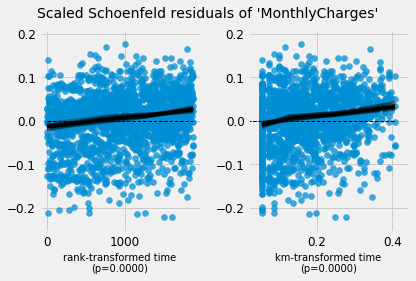

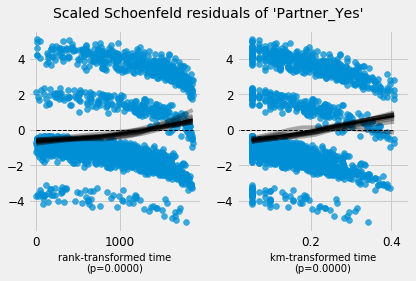

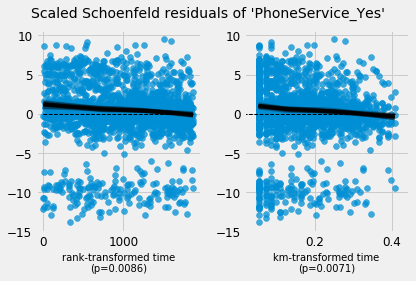

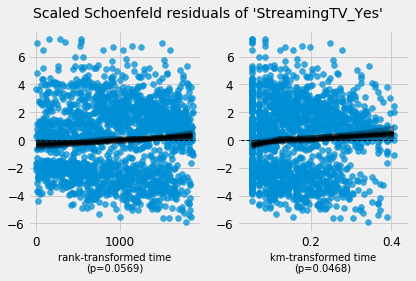

In [26]:
cph.check_assumptions(df_dummy, p_value_threshold=0.05, show_plots=True)

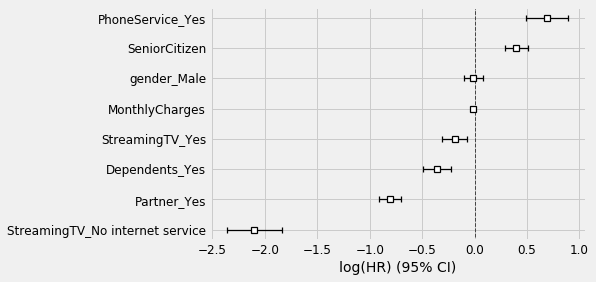

In [27]:
cph.plot()

Results interpretation ----Paste the excel here----

<Figure size 4320x2880 with 0 Axes>

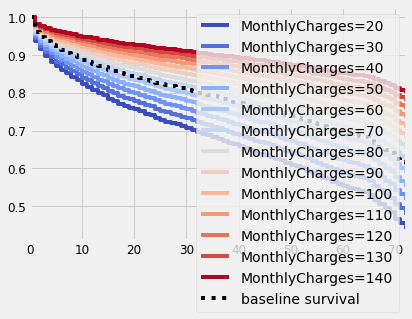

In [39]:
plt.figure(figsize=(60,40))
cph.plot_covariate_groups('MonthlyCharges', values=np.arange(20, 150, 10), cmap='coolwarm')
plt.show()

<Figure size 4320x2880 with 0 Axes>

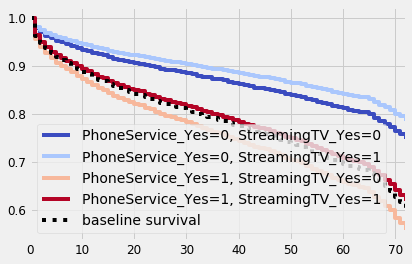

In [40]:
plt.figure(figsize=(60,40))
cph.plot_covariate_groups(['PhoneService_Yes','StreamingTV_Yes'], values=[[0,0],[0,1],[1,0],[1,1]], cmap='coolwarm')
plt.show()

<Figure size 4320x2880 with 0 Axes>

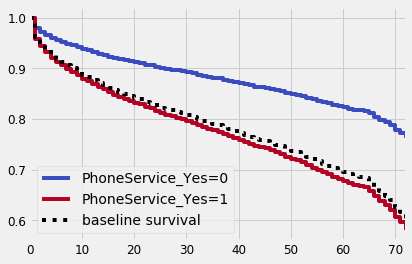

In [41]:
plt.figure(figsize=(60,40))
cph.plot_covariate_groups(['PhoneService_Yes'], values=[0,1], cmap='coolwarm')
plt.show()

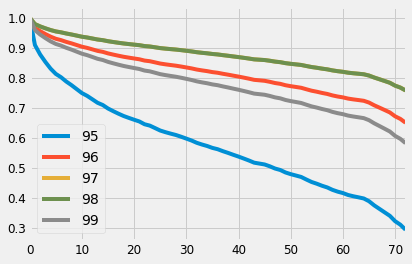

In [50]:
#survival curves:
tr_rows = df_dummy.iloc[95:100,:]
tr_rows
cph.predict_survival_function(tr_rows).plot()

In [53]:
cph.predict_partial_hazard(tr_rows)

,0
95,2.410969
96,0.848601
97,0.546914
98,0.547211
99,1.066333


In [62]:
cph.predict_expectation(tr_rows)

,0
95,41.236612
96,58.710939
97,63.065225
98,63.060745
99,55.794119


In [54]:
cph.predict_median(tr_rows) #inf means that the 

,0.5
95,47.0
96,inf
97,inf
98,inf
99,inf


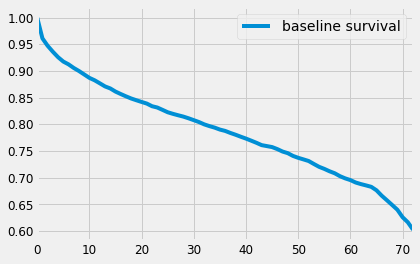

In [57]:
#baseline survival
cph.baseline_survival_.plot()

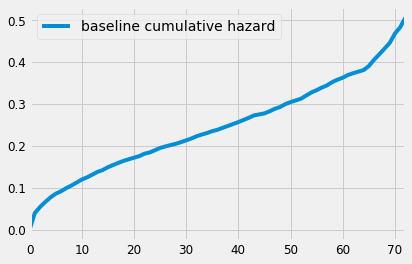

In [59]:
#baseline cummulative hazard
cph.baseline_cumulative_hazard_.plot()

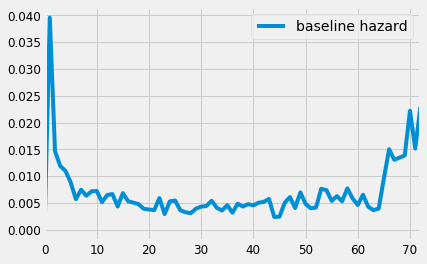

In [60]:
#baseline cummulative hazard
cph.baseline_hazard_.plot()